# AOB MC Data Exploration
The goal of this notebook is to take in data from Zhuang et al. (see other notebooks) and be able to explore spatial transcriptomics of AOB MCs, specifically. This will be done in a few steps including:
* data loading
* joining dataframes
* filtering for excitatory neurons within the accessory olfactory bulb
* visualizing genetic diversity of these neurons

This notebook has been created to enable greater visualization of the analysis performed in AOB_MC_data_exploration.py within this repository. Please note that much of this code has been adapted from code provided by the Allen Brain Institute.

In [1]:
# if using for the first time, you will need to download the Allen Brain-specific functions:
!pip install "abc_atlas_access[notebooks] @ git+https://github.com/alleninstitute/abc_atlas_access.git"

  Cloning https://github.com/alleninstitute/abc_atlas_access.git to c:\users\kevjm\appdata\local\temp\pip-install-rdt01qah\abc-atlas-access_28446a93bb184d7099a6cbd70c4970f1
  Resolved https://github.com/alleninstitute/abc_atlas_access.git to commit 398c9cc557a4b1e75dc68dd3d4965d3ed50367b2
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/alleninstitute/abc_atlas_access.git 'C:\Users\kevjm\AppData\Local\Temp\pip-install-rdt01qah\abc-atlas-access_28446a93bb184d7099a6cbd70c4970f1'


## Imports, Definintions, and Loading of Relevant Data

In [2]:
# import relevant libraries and Allen-specific packages to engage with datasets
import pandas as pd
from pathlib import Path
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

### Defining plotting functions provided by Allen Brain

In [19]:
# defining functions for visualization
# This code has been provided by the Allen Brain Institute
def subplot_section(ax, xx, yy, cc = None, val = None, cmap = None) :
    
    if cmap is not None :
        ax.scatter(xx, yy, s=0.5, c=val, marker='.', cmap=cmap)
    elif cc is not None :
        ax.scatter(xx, yy, s=0.5, color=cc, marker='.')
    ax.set_ylim(11, 0)
    ax.set_xlim(0, 11)
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])


def plot_sections(cell_extended, example_section, cc = None, val = None, fig_width = 10, fig_height = 10, cmap = None) :
    
    fig, ax = plt.subplots(2, 2)
    fig.set_size_inches(fig_width, fig_height)
    
    for i, d in enumerate(cell_extended):
        
        pred = (cell_extended[d]['brain_section_label'] == example_section[d])
        section = cell_extended[d][pred] 
        
        if cmap is not None :
            subplot_section( ax.flat[i], section['x'], section['y'], val=section[val], cmap=cmap)
        elif cc is not None :
            subplot_section( ax.flat[i], section['x'], section['y'], section[cc])
            
        ax.flat[i].set_title(d)
        
    return fig, ax


def plot_heatmap(df, fig_width = 8, fig_height = 4, cmap=plt.cm.magma_r, vmax=None):

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width, fig_height)

    res = ax.imshow(arr, cmap=cmap, aspect='auto', vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels(xlabs)

    ax.set_yticks(range(len(ylabs)))
    # res = ax.set_yticklabels(ylabs)

### Importing data

In [4]:
# labels for all Zhuang datasets
datasets = ['Zhuang-ABCA-1', 'Zhuang-ABCA-2', 'Zhuang-ABCA-3'] #excluding ...-4 as it does not have any AOB neurons
# loading / caching relevant data:
# download_base = Path('C:/Users/IGD/Documents/KJM/data/abc_10x/data/abc_atlas') # work computer
download_base = Path('C:/Users/kevjm/Documents/Python/downloaded_data/ABC_10X') # personal laptop
abc_cache = AbcProjectCache.from_cache_dir(download_base)

## Analysis Pipeline

### Create variable cell_extended to contain data from provided datasets
These next few cells will download and combine relevant data for future analysis. Some notes:
* Cluster refers to the clusters ABI defined based on genes expressed
* CCF refers to the coordinates of a given cell within the ABI centralized framework
* Parcellation refers to the brain area where a cell was found

The steps within the following cells are performed by the create_cell_extended function defined in combining_filtering_abc_data.py within this repository

In [5]:
# Step 1: Reading in cluster details and providing color for consistent labeling
cluster_details = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_pivoted',
    keep_default_na=False
)

cluster_details.set_index('cluster_alias', inplace=True)
cluster_colors = abc_cache.get_metadata_dataframe(
    directory='WMB-taxonomy',
    file_name='cluster_to_cluster_annotation_membership_color',
)
cluster_colors.set_index('cluster_alias', inplace=True)

In [6]:
# Step 2: Load in cell metadata and coordinate information
# for each dataframe (as defined by list above)
print('Creating components...')
cell = {}
ccf_coordinates = {}
for d in datasets :
    #for each dataset, 
    # load in the metadata
    cell[d] = abc_cache.get_metadata_dataframe(
        directory=d,
        file_name='cell_metadata',
        dtype={"cell_label": str}
    )
    cell[d].set_index('cell_label', inplace=True)
    sdf = cell[d].groupby('brain_section_label')          
    print(d,":","Number of cells = ", len(cell[d]), ", ", "Number of sections =", len(sdf))

    # and load in the coordinate information
    ccf_coordinates[d] = abc_cache.get_metadata_dataframe(directory=f"{d}-CCF", file_name='ccf_coordinates')
    ccf_coordinates[d].set_index('cell_label', inplace=True)
    ccf_coordinates[d].rename(columns={'x': 'x_ccf',
                                       'y': 'y_ccf',
                                       'z': 'z_ccf'},
                              inplace=True)

Creating components...
Zhuang-ABCA-1 : Number of cells =  2846908 ,  Number of sections = 147
Zhuang-ABCA-2 : Number of cells =  1227408 ,  Number of sections = 66
Zhuang-ABCA-3 : Number of cells =  1585843 ,  Number of sections = 23


In [7]:
#Step 3: Load in Parcellation Data (defines what brain region a cell is in)
parcellation_annotation = abc_cache.get_metadata_dataframe(directory="Allen-CCF-2020",
                                                           file_name='parcellation_to_parcellation_term_membership_acronym')   
parcellation_annotation.set_index('parcellation_index', inplace=True)
parcellation_annotation.columns = ['parcellation_%s'% x for x in  parcellation_annotation.columns]
parcellation_color = abc_cache.get_metadata_dataframe(directory="Allen-CCF-2020",      
                                                      file_name='parcellation_to_parcellation_term_membership_color')
parcellation_color.set_index('parcellation_index', inplace=True)
parcellation_color.columns = ['parcellation_%s'% x for x in  parcellation_color.columns]

In [8]:
#Step 4: Combine all relevant data into cell_extended variable
cell_extended = {}
for d in datasets :
    cell_extended[d] = cell[d].join(cluster_details, on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(cluster_colors, on='cluster_alias')
    cell_extended[d] = cell_extended[d].join(ccf_coordinates[d], how='inner')
    cell_extended[d] = cell_extended[d].join(parcellation_annotation, on='parcellation_index')
    cell_extended[d] = cell_extended[d].join(parcellation_color, on='parcellation_index')

### Filtering expression data to AOB Glutamatergic Neurons
These cells will select from the whole-brain datasets only those cells that are (1) within the accessory olfactory bulb (AOB) and (2) use glutamate as their neurotransmitter. Within the AOB, glutamatergic neurons are either mitral or tufted cells; here we are combining them as one population.

The steps within the following cells are performed by the filter_cell_extended function defined in combining_filtering_abc_data.py within this repository

In [9]:
# Define filtering parameters
structure_mask = 'AOB'
nt_mask = 'Glut'

# creating a new dataframe only with glutamatergic cells within the olfactory bulb
cell_extended_filt = {}
for key in cell_extended:
    curr_df = cell_extended[key]
    cell_extended_filt[key] = curr_df.loc[
        (curr_df['parcellation_structure'] == structure_mask) &
        (curr_df['neurotransmitter'] == nt_mask)]
    print(f'{key}: {cell_extended_filt[key].shape[0]} {nt_mask}-ergic neurons within {structure_mask}')

Zhuang-ABCA-1: 1050 Glut-ergic neurons within AOB
Zhuang-ABCA-2: 370 Glut-ergic neurons within AOB
Zhuang-ABCA-3: 458 Glut-ergic neurons within AOB


### Add gene expression data to the filtered dataframe
The following cells will retrieve gene expression data for each cell from one dataframe and merge it with the filtered dataframe created above. This will be done through defining a function that takes a dataframe and list of gene names.

With a defined function, we can then add an arbitrary amount of genetic data based on certain genes of interest. The code within the following cells is recapitulated in AOB_MC_data_exploration.py and the function add_gene_expression within the combining_filtering_abc_data.py files within this repository

In [10]:
# First define a function that adds genetic expression data to a dataframe
def add_gene_expression(cell_extended,genes):
    """
    This function incorporates genetic expression data into 
    a cell_extended dictionary of dataframes. cell_extended is a dictionary of 
    dataframes and genes is a dataframe with information for screened genes.
    """
    
    print(f'Finding expression data for {len(genes)} genes')
    # download_base = Path('C:/Users/IGD/Documents/KJM/data/abc_10x/data/abc_atlas') # work computer
    download_base = Path('C:/Users/kevjm/Documents/Python/downloaded_data/ABC_10X') # personal laptop
    abc_cache = AbcProjectCache.from_cache_dir(download_base)
    
    cell_w_genex = {}
    for key in cell_extended:    
        file = abc_cache.get_data_path(directory=key, 
                                       file_name=f"{key}/log2")
        
        adata = anndata.read_h5ad(file, backed='r')
        
        start = time.process_time()
        gdata = adata[:, genes.index].to_df()
        gdata.columns = genes.gene_symbol
        cell_w_genex[key] = cell_extended[key].join(gdata)
        
        print(key,"-","time taken: ", time.process_time() - start)
        
        adata.file.close()
        del adata
    
    return cell_w_genex

With the function defined, we can name the genes of interest. Note that ABC screened for 1k+ genes which could take a bit of time. Below, I have included code that looks at expression data for a select set of genes.

In [11]:
# First, load in all gene expression data
# loading in gene data
genes = abc_cache.get_metadata_dataframe(directory=datasets[0],
                                        file_name='gene')
genes.set_index('gene_identifier', inplace=True)

In [12]:
# you can filter the genes based on a set list, but it must be a dataframe
#for example, here we are selecting a subset of screened genes
gnames = ['Slc17a6','Slc32a1','Gnrh1','Esr1','Esr2','Npy1','Npy2','Cyp19a1','Tac2','Crhr1','Crhr2']
gene_bool = [x in gnames for x in genes.gene_symbol]
genes_filtered = genes[gene_bool]

cell_extended_filt_genex = add_gene_expression(cell_extended_filt,genes_filtered)

Finding expression data for 9 genes
Zhuang-ABCA-1 - time taken:  63.96875
Zhuang-ABCA-2 - time taken:  43.484375
Zhuang-ABCA-3 - time taken:  47.390625


If you wanted to look at the expression data for all genes, then you would skip the filtering step above and pass the genes dataframe as the second argument within the add_gene_expression function.

### Combine separate dataframes into single
Right now, the three datasets (Zhuang...-1, Zhuang...-2, and Zhuang...-3) are stored within a dictionary of dataframes. For cross-experiment analysis, we need to combine them into a single dataframe

In [13]:
#with all data compiled, we can combine across dataframes as follows
df_all_datasets = pd.DataFrame()
for k in cell_extended_filt_genex:
    df_all_datasets = pd.concat([df_all_datasets,
                                 cell_extended_filt_genex[k]])

## Data Visualization

We can now begin visualizing the data! First step is to look at gene expression across neurons for the genes listed above.

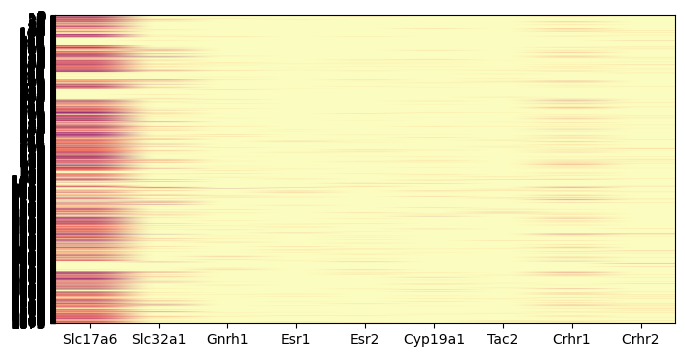

In [20]:
#this line is included in case there are genes within the list that aren't actually in the allen dataset
gnames_in_df = [g_name for g_name in gnames if g_name in df_all_datasets.columns] 
plot_heatmap(df_all_datasets[gnames_in_df])

This plot is difficult to interpret given that each row is an individual neuron (almost 1900!). Fortunately, the Allen Institute has already created cell classes which we can use for data visualization as follows:

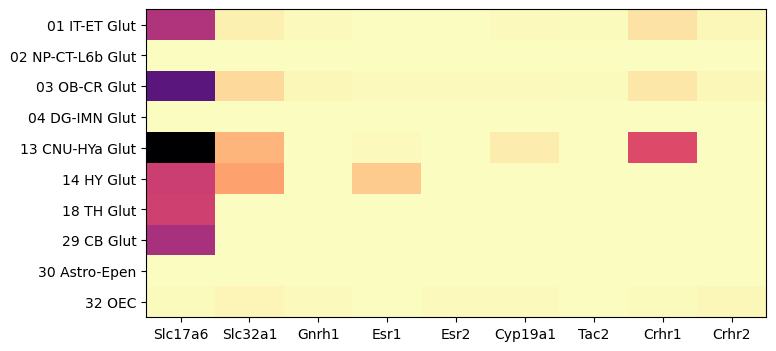

In [15]:
df_gene_exp_by_class = df_all_datasets.groupby('class')[gnames_in_df].mean()
plot_heatmap(df_gene_exp_by_class[gnames_in_df])

Here we can see how provided class labels provide a more interpretable heatmap. Namely, most gluatmatergic neurons express Slc17a6 (vGlut) and only a few express Slc32a1 (vGAT). In addition, the 1-type receptor for CRH seems specifically enhanced in the 13 CNU-HYa Glut class; interestingly, this class alos seems to have some expression of aromatase (Cyp19a1). While these classes are useful, I would like to perform my own classification strategies based on all genes expressed to see if there are more explanatory class labels if we consider just AOB neurons.

This is an ongoing project for me and this notebook (along with the other files within this repository) will be updated accordingly. A few questions that I'd like to tackle first are:
1) What subpopulations of AOB glutamatergic cells are there? We know that ABI has clustered neurons throughout the brain, but can we define our own clusters of AOB neurons? To this end, I anticipate using dimensionality reduction (e.g., PCA) and clustering algorithms (e.g., hierarchical/agglomerative clustering, k-means clustering, etc.).
2) Additionally, these datasets contain genetic expression from male and female mice; I would like to know whether there are any sexually dimorphisms in gene expression. To this end, we can create a sexual dimorphism metric by subtracting the average expression of genes in male datasets from female datasets. From this, we can find whether any genes are more strongly expressed in males or females.
3)  Finally, each cell has an anatomical location within the AOB. Sensory input into the AOB is known to be anatomically separate (i.e., sensory neurons expressing the V1-type receptor innervate the anterior AOB whereas sensory neurons expressing hte V2-type receptor innervate the posterior AOB). Are there any genes that have distinct anatomical patterns of expression? To address this, we can define a histogram across the AP axis within the AOB for each gene. Then, we can create a metric with distribution statistics (e.g., median, standard deviation, skew, etc.) to define whether a gene shows specific anatomical patterning.

## Custom Classification of AOB MCs

Here, I will attempt to address whether we can derive clusters from AOB MC gene expression data. From there, we can define the genes that are most likely to discriminate one type of AOB MC to another. This will be done in a number of steps including: dimensionality reduction, algorithmic clustering, then defining feature importance. Before I attempt this, I will increase the dimensionality of my dataset by including all gene expression into subsequent analyses.

In [21]:
cell_extended_filt_genex = add_gene_expression(cell_extended_filt,genes)
gnames = genes['gene_symbol'].to_list()

Finding expression data for 1122 genes
Zhuang-ABCA-1 - time taken:  379.65625
Zhuang-ABCA-2 - time taken:  153.9375
Zhuang-ABCA-3 - time taken:  161.34375


We can then combine the separate dataframes into a single dataframe:

In [51]:
df_all_datasets = pd.DataFrame()
for k in cell_extended_filt_genex:
    df_all_datasets = pd.concat([df_all_datasets,
                                 cell_extended_filt_genex[k]])

#let's also create a list of all gene names that are within combined dataset
gnames_in_df = [g_name for g_name in gnames if g_name in df_all_datasets.columns]

### Dimensionality Reduction (PCA)

Here I will use principal component analysis (PCA) to reduce genetic expression data. This will help with data visualization and with clustering.

In [52]:
# import relevant packages for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# first scale expression data for PCA
scaler = StandardScaler()
gene_exp_scaled = scaler.fit_transform(df_all_datasets[gnames_in_df])

# define the reduced dimension space as n - 1 where n is the number of genes
n_comp = len(gnames_in_df) - 1

#perform dimensionality reduction
pca = PCA(n_components = n_comp)
pca.fit(gene_exp_scaled)
X_pca = pca.transform(gene_exp_scaled)

# to evaluate dimensionality reduction, we want to know how much cumulative variance each PC explains
# additionally, to reduce complexity of future clustering, I'll perform clustering on the number of dimensions that explain 80% of the data
var_exp_sum = np.cumsum(pca.explained_variance_ratio_)
var_exp_thr_pct = 0.8
dim_n = np.searchsorted(var_exp_sum,var_exp_thr_pct)

### Clustering (k-means clustering)

To cluster into subgroups of AOB MCs, I'll use k-means clustering. For now, I'll set the number of clusters to 4 but we could always come back and adjust this if we feel the need to increase or reduce.

In [53]:
# running KMeans results in a warning regarding OMP_NUM_THREADS. To suppress, run this cell
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [54]:
from sklearn.cluster import KMeans

k = 4
KM = KMeans(n_clusters = k,
            random_state = 11) #setting random state for reproducibility
KM.fit(X_pca[:,:dim_n]);

### Visualizing clusters in PC subspace
We can now look at how clusters relate to each other in PC space and evaluate how well our strategy has worked for finding groupings

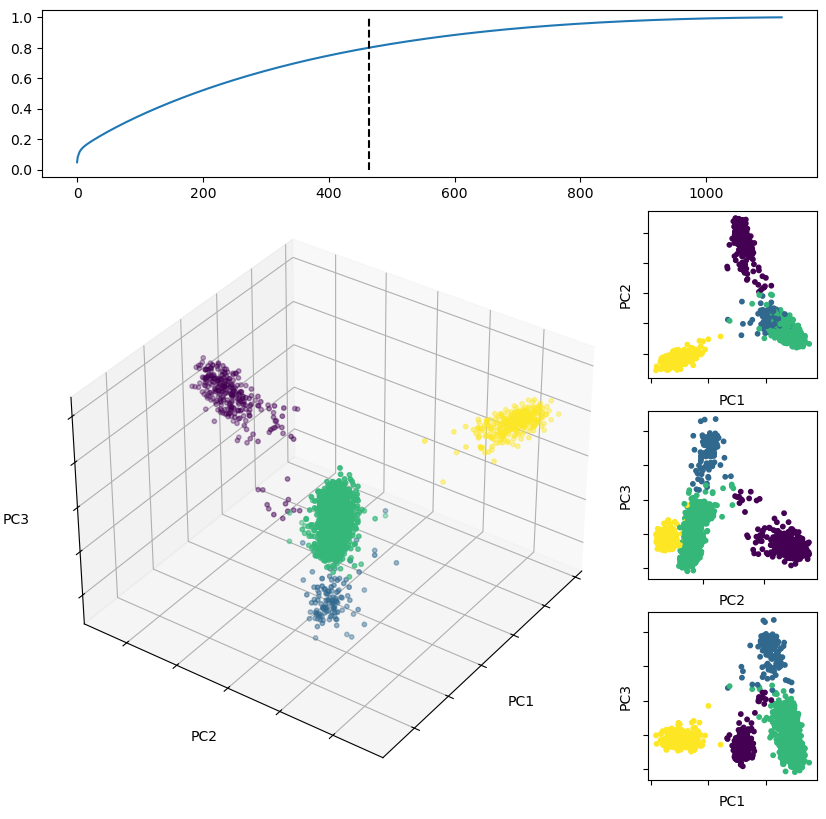

In [57]:
fig = plt.figure(1,figsize = (10,10))
gs = fig.add_gridspec(4,4)

# this plots the cumulative variance explained across principal components
ax1 = fig.add_subplot(gs[0,:])
plt.plot(var_exp_sum)
plt.vlines(x = dim_n,
           ymin = 0, ymax = 1,
           color = 'k',linestyle = '--')

# let's look at the first three components:
# each dot represents a cell within PC subspace color-coded
# by its cluster ID derived from the k-means clustering above
ax2 = fig.add_subplot(gs[1:,0:3],
                      projection = '3d',
                      elev = -145,azim = 145)
scatter = ax2.scatter(
    X_pca[:,0],
    X_pca[:,1],
    X_pca[:,2],
    c = KM.labels_,
    s = 10
);
ax2.set(
    xlabel = 'PC1',
    ylabel = 'PC2',
    zlabel = 'PC3',
);
ax2.xaxis.set_ticklabels([]);
ax2.yaxis.set_ticklabels([]);
ax2.zaxis.set_ticklabels([]);

# next I'm going to plot three 2-d projections of the same data
# just to help with visual inspection
axes = []
pairs = [[0,1],[1,2],[0,2]]
xlbls = ['PC1','PC2','PC1']
ylbls = ['PC2','PC3','PC3']
for ii in range(1,4):
    ax = fig.add_subplot(gs[ii,3])
    axes.append(ax)
    ax.scatter(
        X_pca[:,pairs[ii-1][0]],
        X_pca[:,pairs[ii-1][1]],
        c = KM.labels_,
        s = 10,
    );
    ax.set(
        xlabel = xlbls[ii-1],
        ylabel = ylbls[ii-1]
    );
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

This looks like a good set of clusters! Let's add the cluster identity to the combined dataset

In [58]:
kmlabels = pd.Series(KM.labels_,
                     index = df_all_datasets.index,
                     name = 'kmeans_label')
df_all_datasets['kmeans_label'] = kmlabels

### Feature Importance

Now that we can divide up the AOB MCs into custom-defined groups, let's see if we can figure out what gene(s) are the most important for differentiating among groups. I can do this by looking at the clustering algorithm and by looking at dimensionality reduction

#### Feature Importance - Clustering
Now that we have a set of clusters, we can identify which genes are most variably expressed across clusters

In [60]:
# first, let's find the average gene expression for each cluster
df_klbl_mn = (df_all_datasets.groupby('kmeans_label')
                [gnames_in_df].mean())

# we are interested in genes that are strongly expressed among AOB MCs
col_sums = df_klbl_mn.sum().sort_values(ascending = False)
top_col = col_sums[col_sums > np.percentile(col_sums.to_numpy(),85)]
df_klbl_mn_sub = df_klbl_mn[top_col.index]

# now we'll sort the genes by cross-cluster variance (defined by standard deviation)
col_stds = df_klbl_mn_sub.std().sort_values(ascending = False)
new_col_order = col_stds.index
df_klbl_mn_sub_reorder = df_klbl_mn_sub.reindex(columns = new_col_order)
top_var_gene_list_km = df_klbl_mn_sub_reorder.columns.to_list()

Let's see what the expression looks like for these genes across clusters

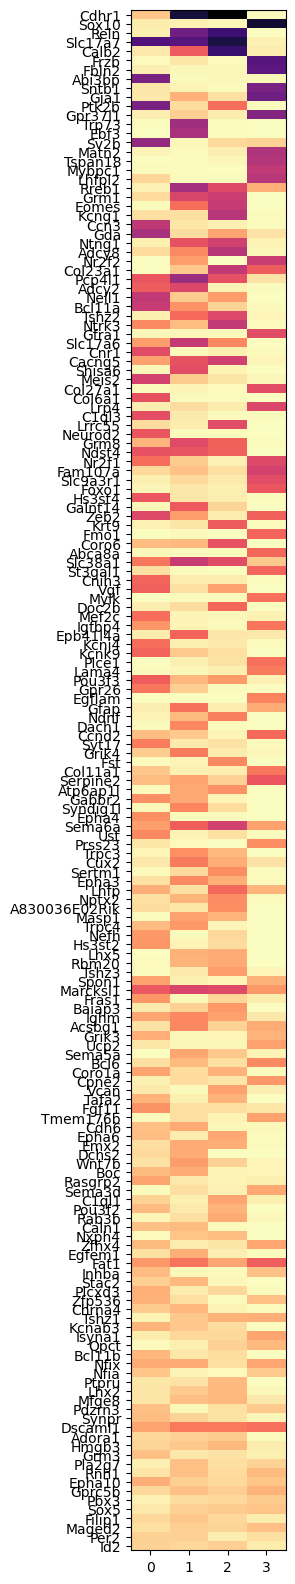

In [63]:
fig, ax = plt.subplots(1,1,figsize = (2,20))
ax.imshow(df_klbl_mn_sub_reorder.to_numpy().transpose(),
          cmap = plt.cm.magma_r,
          aspect = 'auto',
          vmax = None,
          interpolation = None)
ax.set_xticks(range(k))
ax.set_yticks(range(df_klbl_mn_sub_reorder.shape[1]),
              top_var_gene_list_km);

With this heatmap we can see differential gene expression among several genes. For instance, cadherin-1 (Cdhr1) is strongly expressed in clusters 2 and 3 but has little expression in cells of clusters 1 and 4. Similarly, cells of cluster 4 exclusively have high expression of Matn2, Tspan18,Mybpc1, and Lhfpl2.
However, K-Means clustering depends on random initialization. It is possible that these genes are specific to this specific starting parameters of this batch of clustering. To address this, we can iteratively perform k-means clustering and define the genes that are most often variable across clusters

In [67]:
n_runs = 101
k = 4
top_n = 10;
pctle = 0;

all_top_var_genes = []
for rs in range(n_runs):
    # clustering with a new random state
    KM = KMeans(n_clusters = k, random_state = rs)
    KM.fit(X_pca[:,:dim_n])
    kmlabels = pd.Series(KM.labels_,
                         index = df_all_datasets.index,
                         name = 'kmeans_label')
    df_all_datasets['kmeans_label'] = kmlabels

    df_klbl_mn = (df_all_datasets.groupby('kmeans_label')
                  [gnames_in_df]
                  .mean())
    col_sums = df_klbl_mn.sum().sort_values(ascending = False)
    # if we wanted to select for highest-expressing genes, we can pass a percentile here
    # for now, I'm going to look at all genes
    top_col = col_sums[col_sums > np.percentile(col_sums.to_numpy(),pctle)]
    df_klbl_mn_sub = df_klbl_mn[top_col.index]

    # find most variable gene expressions via std
    col_stds = df_klbl_mn_sub.std().sort_values(ascending = False)
    new_col_order = col_stds.index
    df_klbl_mn_sub_reorder = df_klbl_mn_sub.reindex(columns = new_col_order)
    top_var_gene_list = df_klbl_mn_sub_reorder.columns.to_list()
    # limiting output to top N for ease
    all_top_var_genes = all_top_var_genes + top_var_gene_list[:top_n]
    if rs%10==0:
        print(f'--> Completed {rs} runs...')   


--> Completed 0 runs...
--> Completed 10 runs...
--> Completed 20 runs...
--> Completed 30 runs...
--> Completed 40 runs...
--> Completed 50 runs...
--> Completed 60 runs...
--> Completed 70 runs...
--> Completed 80 runs...
--> Completed 90 runs...
--> Completed 100 runs...


In [69]:
# let's turn the list into a useable dataframe that we can build on later
all_top_var_genes = pd.Series(all_top_var_genes)
n_thr = 0 #building in threshold if we want to use at a later time
vc = all_top_var_genes.value_counts()
vc_top = vc.loc[vc>=n_thr]
top_var_gene_list = vc_top.index.to_list()

top_var_gene_names = []
for top_gene in top_var_gene_list:
    top_var_gene_names.append(genes['name']
                              .loc[genes['gene_symbol']==top_gene]
                              .values[0])

df_top_genes_km = vc_top.reset_index()
df_top_genes_km['gene_name'] = top_var_gene_names;
df_top_genes_km['count'] = df_top_genes_km['count']/n_runs;
df_top_genes_km.rename(columns = {'count':'prop_runs'},inplace=True)

With this dataframe, we can now see which genes are most often in the top ten most variable genes across clusters

In [71]:
df_top_genes_km.head(20)

index  prop_runs                                          gene_name
0     Cdhr1   0.960396                   cadherin-related family member 1
1      Reln   0.940594                                             reelin
2     Calb2   0.930693                                        calbindin 2
3   Slc17a7   0.851485  solute carrier family 17 (sodium-dependent ino...
4     Sox10   0.841584              SRY (sex determining region Y)-box 10
5      Frzb   0.811881                           frizzled-related protein
6     Fbln2   0.772277                                          fibulin 2
7     Sntb1   0.574257                                syntrophin, basic 1
8    Abi3bp   0.574257   ABI gene family, member 3 (NESH) binding protein
9      Gja1   0.495050                      gap junction protein, alpha 1
10  Gpr37l1   0.188119               G protein-coupled receptor 37-like 1
11    Ptk2b   0.168317                PTK2 protein tyrosine kinase 2 beta
12   Hs3st4   0.138614  heparan sulfate (glucosamine) 3-O-sulfotransfe...
13     Sv2b   0.118812                  synaptic vesicle glycoprotein 2 b
14    Eomes   0.099010                                       eomesodermin
15      Vgf   0.089109                  VGF nerve growth factor inducible
16      Trh   0.069307                      thyrotropin releasing hormone
17    Trp73   0.059406                  transformation related protein 73
18     Krt9   0.059406                                          keratin 9
19      Fst   0.059406                                        follistatin

Looking at the top 20 genes, it seems that the top ten is pretty consistent with some other genes providing some importance depending on the initial starting points.

#### Feature Importance - PCA
In a parallel analysis of feature importance we can use the results of our PCA. Namely, after dimensionality reduction, each axis (i.e., principal component) has a "loading" (or coefficient) for each gene. The magnitude of this loading is related to how much that gene is weighted on that specific PC. Because of this, we can see what genes have strong loadings across the PCs used for clustering. Moreover, we can determine whether some genes are often given strong loadings on multiple PCs.

In [72]:
# magnitude of loadings across PCs
pc_comps = pca.components_
thr = 0.05 #loading threshold
gene_symbols = genes['gene_symbol'].to_list()
n_largest = 10

top_genes_pca = [];
for pc in range(dim_n):
    # collapsing across all dimensions to find genes with loading magnitudes >= threshold
    bool_list = np.abs(pc_comps[pc,:]>=thr)
    for ii,value in enumerate(gene_symbols):
        if bool_list[ii]:
            top_genes_pca.append(value)

    # finding the n genes with largest loadings on each pc
    top_gene_symbol = (genes['gene_symbol']
                       .iloc[pd.Series(np.abs(pc_comps[pc,:]))
                               .nlargest(n_largest)
                               .index.to_list()]
                      .values
                      .tolist())

    top_gene_name = (genes['name']
                       .iloc[pd.Series(np.abs(pc_comps[pc,:]))
                               .nlargest(n_largest)
                               .index.to_list()]
                      .values
                      .tolist())
    # for each pc, build out two columns for top n genes and concat to dataframe
    dict_temp = {'pc'+str(pc+1)+'_symbol': top_gene_symbol,
                 'pc'+str(pc+1)+'_name': top_gene_name}
    df_temp = pd.DataFrame(dict_temp)
    if pc == 0:
        df_top_genes_per_pc = df_temp
    else:
        df_top_genes_per_pc = pd.concat([df_top_genes_per_pc,df_temp],axis = 1)

# for the most common genes with high loadings on pcs, add more information
top_genes_pca = pd.Series(top_genes_pca)
vc_pca = top_genes_pca.value_counts()
common_genes_list_pca = vc_pca.index.to_list()
common_genes_names_pca = []
for common_gene in common_genes_list_pca:
    common_genes_names_pca.append(genes['name']
                                  .loc[genes['gene_symbol']==common_gene]
                                  .values[0])

df_common_genes_pca = vc_pca.reset_index()
df_common_genes_pca['gene_name'] = common_genes_names_pca
df_common_genes_pca['count'] = df_common_genes_pca['count']/dim_n
df_common_genes_pca.rename(columns = {'index': 'gene_symbol','count': 'prop_pc'},inplace = True);

Now we have a dataframe similar to what we created with iterative clustering above. Namely, we can see which genes often have a strong loading:

In [74]:
df_common_genes_pca.head(20)

gene_symbol   prop_pc                                        gene_name
0        Crhr2  0.103448       corticotropin releasing hormone receptor 2
1        Nr2e1  0.094828  nuclear receptor subfamily 2, group E, member 1
2         Gbx2  0.090517                    gastrulation brain homeobox 2
3         Lhx8  0.088362                           LIM homeobox protein 8
4         Prph  0.088362                                       peripherin
5        Robo3  0.088362                   roundabout guidance receptor 3
6      Lrrc10b  0.088362               leucine rich repeat containing 10B
7       Gas2l3  0.086207                  growth arrest-specific 2 like 3
8        Glp2r  0.084052                 glucagon-like peptide 2 receptor
9        Hoxb8  0.084052                                      homeobox B8
10         Ngf  0.084052                              nerve growth factor
11        Tac2  0.084052                                     tachykinin 2
12       Clrn1  0.084052                                         clarin 1
13       Foxa1  0.084052                                  forkhead box A1
14      Vwa5b1  0.084052    von Willebrand factor A domain containing 5B1
15      Gpr139  0.084052                   G protein-coupled receptor 139
16        Ttc6  0.084052                tetratricopeptide repeat domain 6
17      Gxylt2  0.084052                   glucoside xylosyltransferase 2
18       Foxd2  0.084052                                  forkhead box D2
19     Gm30564  0.081897                            predicted gene, 30564

For example, Crhr2 has a strong loading in ~10% of all PCs. 
In addition, we also have access to the genes with the 10 strongest loadings for each PC. Not that each PC is ordered in increasing amount of variance explained. That is lower PCs explain more variance than highers. Thus, knowing which genes have strong loadings on earlier PCs can reveal which expression patterns are relevant for clustering

In [75]:
df_top_genes_per_pc.head()

pc1_symbol                               pc1_name pc2_symbol  \
0      Cdhr1       cadherin-related family member 1     Abi3bp   
1      Sox10  SRY (sex determining region Y)-box 10      C1ql3   
2       Frzb               frizzled-related protein    Neurod2   
3      Sntb1                    syntrophin, basic 1     Bcl11a   
4      Fbln2                              fibulin 2       Ccn3   

                                           pc2_name pc3_symbol  \
0  ABI gene family, member 3 (NESH) binding protein      Trp73   
1                                        C1q-like 3       Ebf3   
2                      neurogenic differentiation 2     Shisa6   
3     B cell CLL/lymphoma 11A (zinc finger protein)      Dach1   
4           cellular communication network factor 3   Epb41l4a   

                                        pc3_name pc4_symbol  \
0              transformation related protein 73      Rxfp1   
1                          early B cell factor 3     Hs3st4   
2                          shisa family member 6     Hs3st2   
3        dachshund family transcription factor 1      Htr1d   
4  erythrocyte membrane protein band 4.1 like 4a      Myo5b   

                                            pc4_name pc5_symbol  \
0     relaxin/insulin-like family peptide receptor 1        Fst   
1  heparan sulfate (glucosamine) 3-O-sulfotransfe...      Cbln1   
2  heparan sulfate (glucosamine) 3-O-sulfotransfe...      Nxph4   
3        5-hydroxytryptamine (serotonin) receptor 1D     Baiap3   
4                                          myosin VB      Mdga1   

                                            pc5_name  ... pc460_symbol  \
0                                        follistatin  ...       Fam43a   
1                     cerebellin 1 precursor protein  ...          Vit   
2                                    neurexophilin 4  ...         Casr   
3                          BAI1-associated protein 3  ...         Pkp2   
4  MAM domain containing glycosylphosphatidylinos...  ...         Lgr6   

                                          pc460_name pc461_symbol  \
0       family with sequence similarity 43, member A         Myl4   
1                                             vitrin       Pcdh20   
2                           calcium-sensing receptor        Galr1   
3                                      plakophilin 2     Pafah1b3   
4  leucine-rich repeat-containing G protein-coupl...        Hoxb3   

                                          pc461_name pc462_symbol  \
0                        myosin, light polypeptide 4       Ankfn1   
1                                   protocadherin 20      Adamts2   
2                                 galanin receptor 1        Meis1   
3  platelet-activating factor acetylhydrolase, is...         Bcl6   
4                                        homeobox B3        Cbln2   

                                          pc462_name pc463_symbol  \
0  ankyrin-repeat and fibronectin type III domain...       Slc6a4   
1  a disintegrin-like and metallopeptidase (repro...        Cnga3   
2                                    Meis homeobox 1          Vdr   
3                         B cell leukemia/lymphoma 6        Casz1   
4                     cerebellin 2 precursor protein     Arhgap36   

                                          pc463_name pc464_symbol  \
0  solute carrier family 6 (neurotransmitter tran...       Gas2l3   
1            cyclic nucleotide gated channel alpha 3        Kcng4   
2      vitamin D (1,25-dihydroxyvitamin D3) receptor        Adcy7   
3                               castor zinc finger 1       Ccdc80   
4                   Rho GTPase activating protein 36       Osbpl3   

                                          pc464_name  
0                    growth arrest-specific 2 like 3  
1  potassium voltage-gated channel, subfamily G, ...  
2                                adenylate cyclase 7  
3                   coiled-coil domain containing 80  
4                   oxysterol binding protein-

#### Combining Feature Importance Metrics
Now that we have a few metrics for feature importance, let's merge them into a single dataframe. Namely, we can take the genes that were often variable across identified clusters and find whether they were ever in the top 10 loadings of PCs (and, if so, the first instance). Moreover, we can also append the proportion of PCs wherein they have strong loadings.

In [79]:
first_pc = []
for idx in range(len(df_top_genes_km)):
    top_gene_km = df_top_genes_km['index'].iloc[idx]
    counter = 0
    for col_num in range(0,df_top_genes_per_pc.shape[1],2):
        counter += 1
        pc_gene_list = df_top_genes_per_pc.iloc[:,col_num].to_list()
        if top_gene_km in pc_gene_list:
            first_pc.append(counter)
            break
df_top_genes_km['first_obs_pc'] = pd.Series(first_pc)
df_top_genes_merged = pd.merge(df_top_genes_km,df_common_genes_pca,
                               how = 'left',
                               left_on = 'index',
                               right_on = 'gene_symbol')
col_order = ['gene_symbol','gene_name','prop_runs','first_obs_pc','prop_pc']
df_top_genes_merged = (df_top_genes_merged
                       .drop(columns = ['gene_symbol','gene_name_y'])
                       .rename(columns = {'index': 'gene_symbol','gene_name_x': 'gene_name'})
                       .reindex(columns = col_order)
                      )

In [81]:
df_top_genes_merged.head(20)

gene_symbol                                          gene_name  prop_runs  \
0        Cdhr1                   cadherin-related family member 1   0.960396   
1         Reln                                             reelin   0.940594   
2        Calb2                                        calbindin 2   0.930693   
3      Slc17a7  solute carrier family 17 (sodium-dependent ino...   0.851485   
4        Sox10              SRY (sex determining region Y)-box 10   0.841584   
5         Frzb                           frizzled-related protein   0.811881   
6        Fbln2                                          fibulin 2   0.772277   
7        Sntb1                                syntrophin, basic 1   0.574257   
8       Abi3bp   ABI gene family, member 3 (NESH) binding protein   0.574257   
9         Gja1                      gap junction protein, alpha 1   0.495050   
10     Gpr37l1               G protein-coupled receptor 37-like 1   0.188119   
11       Ptk2b                PTK2 protein tyrosine kinase 2 beta   0.168317   
12      Hs3st4  heparan sulfate (glucosamine) 3-O-sulfotransfe...   0.138614   
13        Sv2b                  synaptic vesicle glycoprotein 2 b   0.118812   
14       Eomes                                       eomesodermin   0.099010   
15         Vgf                  VGF nerve growth factor inducible   0.089109   
16         Trh                      thyrotropin releasing hormone   0.069307   
17       Trp73                  transformation related protein 73   0.059406   
18        Krt9                                          keratin 9   0.059406   
19         Fst                                        follistatin   0.059406   

    first_obs_pc   prop_pc  
0            1.0  0.002155  
1            1.0  0.002155  
2            1.0  0.004310  
3            1.0  0.002155  
4            1.0       NaN  
5            1.0       NaN  
6            1.0       NaN  
7            2.0       NaN  
8            1.0  0.002155  
9            4.0       NaN  
10           2.0       NaN  
11           6.0  0.004310  
12           8.0  0.006466  
13           3.0  0.004310  
14           5.0  0.006466  
15           2.0  0.008621  
16           7.0  0.012931  
17           3.0  0.002155  
18          12.0  0.006466  
19           1.0  0.004310

Taken together, we can see that for the most part, the most common genes found through k-means analysis are in lower PCs but do not often have strong loadings across many PCs. In the future, I'd like to see if we can perform PCA/clustering with reduced gene expression (e.g., only receptors) to see if there are interesting co-expression patterns of genes with more straight-forward relevance for behavior.